# Preface
In this Jupyter Notebook we'll learn how to train a convolutional neural network to classify images stored in the MNIST Dataset. The code has been tested with Python 3.7.6 and Pytorch 1.7.1.

**Note: This is still a work in progress.**  <br>

## 0. Understanding the MNIST dataset
The MNIST database is a classic for machine learning practioners. It contains images of handwritten digits from 0 to 9, and therefore can be deemed as an image classification problem. The MNIST database has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size gray-scale image of 28x28 pixels.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. Detailed information of the dataset can be found on http://yann.lecun.com/exdb/mnist/.


## 1. Accessing the MNIST dataset from PyTorch
It is easy to download the MNIST dataset from PyTorch's torchvision package, which consists of popular datasets, model architectures, and common image transformations for computer vision. First, let's import the necessary modules.



In [1]:
import torch
import torchvision

Next, let's download the dataset and save it under a "data" directory under our present working directory. In the meantime we will also do a few things: 
1. Define a "transform" function to (a) resize the images to 32 by 32 gray-scale pixels to conform with LeNet-5 convolutional neural network input format, and (b) convert downloaded PIL images of range [0,1] to tensors of range [-1, 1].
2. Use PyTorch's DataLoader utility to define how we want to load the image data in minibatches.

A little bit more explanation on the Normalize function in the transform function. Basically it does the following for each channel:
- image = (image - mean) / std

Here we will set the both the parameters mean and std to 0.5. This will normalize the image in the range [-1, 1]. For example, the minimum value 0 will be converted to (0 - 0.5) / 0.5 = -1, the maximum value of 1 will be converted to (1 - 0.5) / 0.5 = 1. If you would like to get your image back in [0, 1] range, you could use,

- image = ((image * std) + mean)

In [2]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), 
     torchvision.transforms.Resize([32,32]),
     torchvision.transforms.Normalize(mean=0.5, std=0.5)])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

bs = 10 # define the minibatch size
trainloader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=False, num_workers=4)

classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9') # the classes for hand-written digits

In [3]:
# Verify the size downloaded datasets
print(len(train_set), len(test_set))
print(type(train_set))

60000 10000
<class 'torchvision.datasets.mnist.MNIST'>


Next, let's view a few sample images to see what they look like.

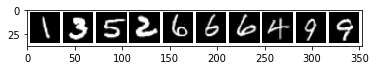

Image Labels:      1     3     5     2     6     6     6     4     9     9


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# define function to show image
def show(img):
    npimg = img.numpy()     # conver to a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest') # https://numpy.org/doc/stable/reference/generated/numpy.transpose.html
    plt.show()
    
# get a random minibatch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
show(torchvision.utils.make_grid(images, nrow=10, padding=3, normalize=True, range=(-1,1), pad_value=1)) # https://pytorch.org/docs/stable/torchvision/utils.html

# print labels
print('Image Labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(bs)))

We can also confirm the image dimension in our minibatch.

In [5]:
print(images.shape) # ([Number of examples, Number of input channel, Image height, Image width])

torch.Size([10, 1, 32, 32])


## 2. Define a Convolutional Neural Network

We will start by building the classic LeNet-5 Convolutional Neural Network and gradually improve it.

References:
1. http://yann.lecun.com/exdb/lenet/
2. https://www.coursera.org/learn/convolutional-neural-networks/lecture/MmYe2/classic-networks
3. https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

The structure of LeNet-5 is as follows: <br>
Input image <br>
&nbsp;&nbsp;-> Convolutional (Conv) layer (6 filters, kernel size: 5 by 5, stride: 1, padding: 2) -> ReLU <br>
&nbsp;&nbsp;-> Avg pooling layer (kernel size: 2, stride: 2) <br>
&nbsp;&nbsp;-> Conv layer (16 filters, kernel size: 5 by 5, stride: 1) -> ReLU <br>
&nbsp;&nbsp;-> Avg pooling layer (kernel size: 2, stride: 2) -> view (similar to numpy's reshape) <br>
&nbsp;&nbsp;-> Fully Connected (FC) linear layer of 120 neurons -> ReLU <br>
&nbsp;&nbsp;-> FC linear layer of 84 neurons -> ReLU <br>
&nbsp;&nbsp;-> Output linear layer of 10 neurons <br>
&nbsp;&nbsp;-> Prediction

We will implement Rectified Linear Unit (ReLU) function as the activation function for the Convolutional layers. ReLU sets x = max(0,x) and has the advantage of avoiding vanishingly small gradients in deep neural networks, efficient computation, and sparse activation (since hidden units with negative inputs are set to 0 and therefore ignored).

Here we aim to define a simpler network to begin with. There are a couple of ideas we will try to explore later in this notebook to enhance our network's initial performance -- such as hidden unit dropouts, batch normalization, parameter regularization, usage of maxpooling layer instead of average pooling, differerent optimization schemes for speeding up computations (e.g., conventional gradient desent, momentum, RMSProp, Adam etc.), and data augmentation etc.

Let's begin by defining a basic LeNet5.
         

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0) # Cin (for gray scale image we only have 1 channel), Cout, Kernel size
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # first run conv layer, then the relu activation function, then 2D pooling
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = LeNet5()

Next we will use PyTorch's "optim" package to pick an optimization algorithm of interest. Let's use the basic Stochastic Gradient Descent approach with momentum as a start.

In [7]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # common beta selection for momentum is 0.9; learning rate is a hyperparameter to be tuned

Next let's define the loss function. Here we will use the cross-entropy loss for this multi-class classification problem. The function computes the LogSoftmax loss over a minibatch of training examples. (See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for details.) 

Compared to the nn.CrossEntropyLoss() used below, an alternative way to is define our loss by calling F.cross_entropy(). The main difference between the two approaches is that when defining the loss using the nn module the state of the network's weights is saved. Therefore, when weights are used to calculate the loss, as in the case of where we want to more accurately avoid the mis-classification of a certain class compared to the others, the nn version of cross-entropy loss definition is more convenient as the weights won't need to be passed every single time the loss function is called. In the case where there's no weighted loss involved, these two approaches are equivalent.

In [8]:
criterion = nn.CrossEntropyLoss()

## 3. Train the network


In [9]:
# import IPython.core.debugger as ipdb # for debugging purposes

num_epoch = 3 # number of loops through the epoch
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    
    # Use enumerate to return a counter along with the data, e.g., (0, [inputs_0, labels_0]), (1, [inputs_1, labels_1]) etc.
    for i, data in enumerate(trainloader, start=0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         ipdb.set_trace() # for debugging
        
    
        # zero the parameter gradients per minibatch otherwise the gradients will be accumulated
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) # this automatically calls the forward function on the minibatch dataset of size bs
        loss = criterion(outputs, labels) # compute the loss using previously defined function
        loss.backward() # back proppagation to compute gradients
        optimizer.step() # update the neural network parameters

        # print statistics
        running_loss += loss.item() # CrossEntropy or other loss functions is divided by the number of elements i.e. the reduction parameter is mean by default.
        
        if i % 2000 == 1999:    # print every 2000 mini-batches, each minibatch has bs examples
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0 # reset averaged minibatch running loss to benchmark progress of training

print('Finished Training')

[1,  2000] loss: 1.337
[1,  4000] loss: 0.274
[1,  6000] loss: 0.191
[2,  2000] loss: 0.140
[2,  4000] loss: 0.125
[2,  6000] loss: 0.110
[3,  2000] loss: 0.087
[3,  4000] loss: 0.085
[3,  6000] loss: 0.084
Finished Training


Let's quickly save our trained model:



In [10]:
PATH = './MNIST_NET.pt'
torch.save(model.state_dict(), PATH)

# we can use torch.load() to retrieve state, and load_state_dict() to restore loaded state to a model
# example 1:
# torch.save(m.state_dict(), 'mymodule.pt')
# m_state_dict = torch.load('mymodule.pt')
# new_m = MyModule()
# new_m.load_state_dict(m_state_dict)

# example 2:
# model = LeNet5()
# model.load_state_dict(torch.load(PATH))

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

## 4. Test the network on the test data


We have trained the network for 3 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



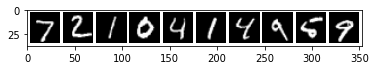

Ground Truth:      7     2     1     0     4     1     4     9     5     9


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
show(torchvision.utils.make_grid(images, nrow=10, padding=3, normalize=True, range=(-1,1), pad_value=1)) # https://pytorch.org/docs/stable/torchvision/utils.html
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(bs)))

We can do a small test on this minibatch to see how our CNN performs. The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network thinks that the image is of the particular class.
So, we will get the index of the highest energy. And since we are predicting handwritten digits, the number returned by the label happen to match the classes that represent the numbers from 0 to 9. Therefore we don't need to define the use the classes separately for this MNIST dataset. That is, classes[labels[i]] and labels[i] are the same number.

In [12]:
outputs = model(images)
# print(outputs.shape)
values, pred = torch.max(outputs, 1)
print("Labels: ", labels.tolist())
print("Prediction: ", pred.tolist())
print("Accuracy: ", (pred == labels).sum().item() / pred.numel() * 100, "%")

Labels:  [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
Prediction:  [7, 2, 1, 0, 4, 1, 4, 9, 6, 9]
Accuracy:  90.0 %


The result on this minibatch seems pretty good. Let us look at how the network performs on the whole dataset.

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

print('Accuracy of the network on the %d test images: %.2f %%' % 
      (total, 100 * correct / total))

Accuracy of the network on the 10000 test images: 97.48 %


That looks much better than making random guesses, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learned something. We can also check what are the classes that performed well, and the classes that did not perform well:



In [14]:
# import IPython.core.debugger as ipdb  # for debugging

class_correct = list(0. for i in range(10)) # initialize a list of 10 floats
class_total = list(0. for i in range(10))

# since we are making predictions, it's unnecessary to save gradient data, hence we'll remove that part to save time and memeory
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        
#         ipdb.set_trace()  # for debugging
        c = (pred == labels).squeeze()
        
        for i in range(bs):
            label = labels[i] 
            class_correct[label] += c[i].item() # will add 1 to class_correct[label] if prediction matches label
            class_total[label] += 1

for i in range(10):
    print('Accuracy of predicting %3s : %.2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of predicting   0 : 99.18 %
Accuracy of predicting   1 : 99.12 %
Accuracy of predicting   2 : 99.13 %
Accuracy of predicting   3 : 98.02 %
Accuracy of predicting   4 : 97.86 %
Accuracy of predicting   5 : 91.93 %
Accuracy of predicting   6 : 98.02 %
Accuracy of predicting   7 : 96.69 %
Accuracy of predicting   8 : 97.74 %
Accuracy of predicting   9 : 96.33 %


These results are already pretty impressive, but the 5's 7's, 8's and 9's seemed to have some room for improvement. At a first glance, we might have the tendency to dive deep directly and start implementing new ideas or modifying existing network structures to seek for improvement. But those efforts could easily take weeks and even months to mature. Before getting overly committed, let's seek for some additional information to see if our network can actually perform better when we invest more time in it...

So let's recap, now we know that when the model is trained on 60,000 examples with 3 epochs the accuracy is ~97%. The first question that comes into mind is: is this a good accuracy?

We'll have to go back to machine learning fundamentals to seek for the answer. In theory, the maximum of accuracy of any problem is bounded by the Bayes Optimal Error, and in many cases the value is an unknown. However, we can approximate the Bayes Error using human-level performance. For example, maybe a regular human like myself can at most recognize 98% of handwritten numbers then we might think our model isn't too bad. But if more research shows that a group of avid readers can recognize 99.9% of the digits in the MNIST dataset then we might think "oh the model is actually just okay but not great." Then in this latter case we know Bayes error is < 0.1% since a group of experts can already achieve such an error margin, and as a result we'd say our model at least has some room for improvement: (99.9% - 97%) = 2.9%. We would call this 2.9% difference between human-level performance and model performance the "avoidable bias".

So let's do a bit of google search and that leads us to this paper: https://arxiv.org/pdf/1202.2745.pdf
and this github sharing: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

According to the paper, human error rate can reach ~0.2%, and a similar level of performance was attained by some research papers published circa. 2010-2016. Therefore we know there's certain room for improving our CNN model!

We'll use 97% accuracy as our baseline and see if we can improve that to 99% or above.

But in order to do that, first of all, we should randomly split our training set into a sub-training set of 50,000 examples and a development (dev) set of 10,000 examples. The purpose of having a separate dev set for model/hyperparameter-tuning is because we don't want to overfit our test set. In other words, we want to prevent the model from "seeing" the test set before any performance evaluation so that we can have an unbiased accuracy estimation of our model when making predictions based on the test set.

In [15]:
train_set, dev_set = torch.utils.data.random_split(train_set, [50000, 10000],generator=torch.Generator().manual_seed(105))

In [16]:
# confirm the length of new training and dev set
print('New training set size: ', len(train_set))
print('New dev set size: ', len(dev_set))

New training set size:  50000
New dev set size:  10000


In [17]:
# Reload our data to have the right iterable
bs = 10 # define the minibatch size, this is also another hyperparameter we may change later
trainloader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)
devloader = torch.utils.data.DataLoader(dev_set, batch_size=bs, shuffle=True, num_workers=4) # we shuffle the dev since we'll tune hyperameter based on dev set
testloader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=False, num_workers=4)

## 5. Fine-tuning the CNN model

OK, now we've decided to fine-tune our model...

### It's brainstorming time... where to adjust?
**Tackling Avoidable Bias Problem between human-level performance and model performance** <br>

*Network Archetecture*
1. Change from Average Pooling to Max Pooling or other pooling methods. Hypothesis: The average pooling function may blur the gray-scale pixel boundaries of a handwritten digit, which may affect model performance.
2. Train the model longer with more epochs & optimize minibatch size etc.
3. Try a different Optimization algorithm, e.g., Adam, RMSprop etc. Hypothesis: the problem has several local optima and we may find a better optima than what we currently are able to get from minibatch SGD with momentum. More insights: https://towardsdatascience.com/overview-of-various-optimizers-in-neural-networks-17c1be2df6d5#:~:text=Optimizers%20are%20algorithms%20or%20methods,problems%20by%20minimizing%20the%20function.
4. Following above, we can perform hyperparameter-tuning using the dev set after we settle on the choice of optimizer using training set.
5. Change activation function (e.g, tanh, ReLU / Leaky ReLU etc.), apply batch normalization etc.
6. We can train a bigger model. For example, more Conv layers, or more filters in existing Conv layers. There are also plenty of more complex network architecture to try as well, for example, AlexNet, Inception module, ResNet etc. We might be able to find some online github repo and perform transfer learning using pre-trained weights for this task as well.

Note: we may need to iterately go through some of these steps for improvements.



**Tackling High Variance Problem between Training set and Dev set performance (i.e. when we start overfitting our training set)** <br>
1. Get more data, apply data augmentation by mirroring or apply random crops etc.
2. Regularization: L2, dropouts, data augmentation may help as well.
3. Change network architecture / perform hyperparameter search.


Luckily in this MNIST classification problem our training / dev / test sets are from the same distribution with the same pre-processing steps applied to all data. If in some other problems we have datasets from different distribution then we might have to create a train-dev set to identify the "avoidable bias", "high variance", and "data mismatch" problem separately. Note: always use the data we care most about in the dev and test sets to set the bull's eye at the right place!

Now we have some ideas and hypotheses, let's try to (in)validate them!

### First of all, let's try to visualize the effect of pooling layers to see what they actually do.

Raw Images


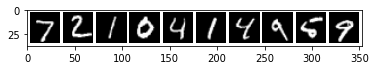

Max Pooled Images


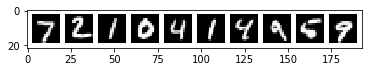

Avg Pooled Images


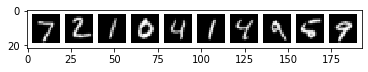

Power Pooled (P=1, sum pooled) Images


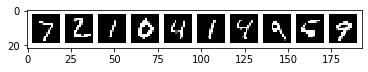

Power Pooled (P=1e8) Images


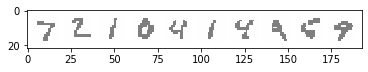

In [18]:
MP = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
AP = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
PP1 = nn.LPPool2d(1, kernel_size=2, stride=2) #power pooing, p=1 is sum pooling, p=Inf is max pooling
PP2 = nn.LPPool2d(1e8, kernel_size=2, stride=2) #power pooing, p=1 is sum pooling, p=Inf is max pooling

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
print("Raw Images")
show(torchvision.utils.make_grid(images, nrow=10, padding=3, normalize=True, range=(-1,1), pad_value=1)) # https://pytorch.org/docs/stable/torchvision/utils.html

print("Max Pooled Images")
show(torchvision.utils.make_grid(MP(images), nrow=10, padding=3, normalize=True, range=(-1,1), pad_value=1)) # https://pytorch.org/docs/stable/torchvision/utils.html

print("Avg Pooled Images")
show(torchvision.utils.make_grid(AP(images), nrow=10, padding=3, normalize=True, range=(-1,1), pad_value=1)) # https://pytorch.org/docs/stable/torchvision/utils.html

print("Power Pooled (P=1, sum pooled) Images")
show(torchvision.utils.make_grid(PP1(images), nrow=10, padding=3, normalize=True, range=(-1,1), pad_value=1)) # https://pytorch.org/docs/stable/torchvision/utils.html

print("Power Pooled (P=1e8) Images")
show(torchvision.utils.make_grid(PP2(images), nrow=10, padding=3, normalize=True, range=(-1,1), pad_value=1)) # https://pytorch.org/docs/stable/torchvision/utils.html

As can be see from above, max pool and sum pool seem to give sharper edges when visually inspected with naked eye compared to the avg pooling approach. Now let's test their individual performance. *Note: change the self.pool definition of the LeNet5 class below to modify the pooling layer mechanism.*

In [49]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0) # Cin (for gray scale image we only have 1 channel), Cout, Kernel size
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.pool = nn.LPPool2d(1, kernel_size=2, stride=2) #power pooing, p=1 is sum pooling, p=Inf is max pooling
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # first run conv layer, then the relu activation function, then 2D pooling
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_model():        
    model = LeNet5()
    # define optimization algorithm and loss function
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # common beta selection for momentum is 0.9; learning rate is a hyperparameter to be tuned
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion

# Train model
def train_model(num_epoch, model, optimizer, criterion, verbose=True):
    for epoch in range(num_epoch):  # loop over the dataset multiple times

        running_loss = 0.0

        for i, data in enumerate(trainloader, start=0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients per minibatch
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs) # this automatically calls the forward function on the minibatch dataset of size bs
            loss = criterion(outputs, labels) # compute the loss using previously defined function
            loss.backward() # back proppagation to compute gradients
            optimizer.step() # update the parameters

            if verbose:
                # print statistics
                running_loss += loss.item() # CrossEntropy or other loss functions is divided by the number of elements i.e. the reduction parameter is mean by default.

                if i % 2000 == 1999:    # print every 2000 mini-batches, each minibatch has bs examples
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0 # reset averaged minibatch running loss to benchmark progress of training

    print('Finished Training')


def test_model(iterator, model, verbose=True):
    # Test model performnance on dev set
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in devloader:
            images, labels = data
            outputs = model(images)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
    accuracy = 100. * correct / total
    if verbose:
        print('Accuracy of the network on the %d dev set images: %.2f%%' % (total, accuracy))
        
    return accuracy

In [50]:
# Note: Change the verbose to False to output less training progress
num_of_instances = 5
model_performance = np.zeros(num_of_instances)
for i in range(num_of_instances):
    model, optimizer, criterion = get_model()
    train_model(3, model, optimizer, criterion, verbose=True) # train with 3 epochs
    model_performance[i] = test_model(devloader, model, verbose=True)
print("averaged model performance: %.2f%%" % np.mean(model_performance))

[1,  2000] loss: 1.760
[1,  4000] loss: 0.303
[2,  2000] loss: 0.150
[2,  4000] loss: 0.127
[3,  2000] loss: 0.087
[3,  4000] loss: 0.085
Finished Training
Accuracy of the network on the 10000 dev set images: 97.68%
[1,  2000] loss: 1.803
[1,  4000] loss: 0.285
[2,  2000] loss: 0.129
[2,  4000] loss: 0.106
[3,  2000] loss: 0.085
[3,  4000] loss: 0.077
Finished Training
Accuracy of the network on the 10000 dev set images: 96.92%
[1,  2000] loss: 1.054
[1,  4000] loss: 0.253
[2,  2000] loss: 0.140
[2,  4000] loss: 0.115
[3,  2000] loss: 0.081
[3,  4000] loss: 0.082
Finished Training
Accuracy of the network on the 10000 dev set images: 97.78%
[1,  2000] loss: 1.214
[1,  4000] loss: 0.272
[2,  2000] loss: 0.159
[2,  4000] loss: 0.123
[3,  2000] loss: 0.096
[3,  4000] loss: 0.085
Finished Training
Accuracy of the network on the 10000 dev set images: 97.50%
[1,  2000] loss: 1.343
[1,  4000] loss: 0.270
[2,  2000] loss: 0.145
[2,  4000] loss: 0.120
[3,  2000] loss: 0.088
[3,  4000] loss: 0.07

Here is an example of model accuracy on dev set from different pooling mechanisms, averaged over 5 instances:
1. AvgPooling: 97.91%, 97.35%, 97.28%, 97.48%, 97.28%; average: **97.46%**
2. MaxPooling: 98.27%, 97.97%, 98.10%, 97.90%, 97.82%; average: **98.01%**
3. SumPooling: 98.11%, 98.43%, 98.25%, 98.72%, 98.60%; average: **98.42%**

The results shows the sum pooling approach gives a higher model accuracy than max and average pooling. It also implies that when the image is sharper the algorithm may have an easier time to distinguish it. Note that here we only training our Convolution Neural Network with 3 epochs. Let's try to visualize how the dev set accuracy changes if we train our model with a larger number of epochs.